In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
dTrain = pd.read_csv('Titanic_training_set.csv')
dTrain.drop(dTrain.columns[0],axis=1,inplace=True)
dTest = pd.read_csv('Titanic_test_set.csv')
dTest.drop(dTest.columns[0],axis=1,inplace=True)

X = dTrain.drop(['Survived','Title_Lady.','Title_Major.','Title_Mlle.','Title_Ms.','Title_Sir.','Deck_T','Title_Capt.','Title_Col.'], axis=1)
y = dTrain['Survived']
X_test = dTest

In [21]:
#Split set into train and CV sets
from sklearn.model_selection import train_test_split

X_train, X_CV, y_train, y_CV = train_test_split(X, y, test_size=0.2)

In [34]:
#Loosely select top features
from sklearn.feature_selection import f_classif, SelectKBest

selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)
mask = selector.get_support(indices=True)
cols = X_train.columns[mask]
X_train_reduced = X_train[cols]

#Adjust X_CV and X_Test accordingly
X_CV_reduced = X_CV[cols]
X_test_reduced = X_test[cols]

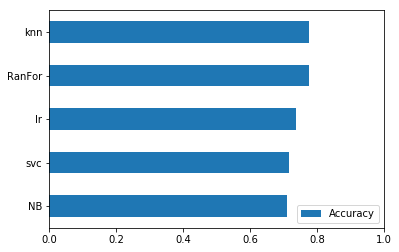

In [61]:
#Identify best classification algorithms with standard hyperparameters
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

algs_name = ['lr','RanFor','svc','NB','knn']
algs = [LogisticRegression(), RandomForestClassifier(), SVC(), GaussianNB(),KNeighborsClassifier()]
acc_table = pd.DataFrame(index = algs_name, columns = ['Accuracy'])

j=0 #iterator
for c in algs:
    c.fit(X_train_reduced, y_train)
    y_pred = c.predict(X_CV_reduced)
    acc_table.iloc[j,0] = accuracy_score(y_CV, y_pred)
    j+=1
    
acc_table.sort_values(by='Accuracy').plot(kind='barh', xlim=(0,1))

In [68]:
#Identify best parameters with Grid Search on top 3 algs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
knn_param = {'n_neighbors':[5,10,20,30,40],
            'leaf_size':[1,3,5],
            'algorithm':['auto','kd_tree']}

knn_grid = GridSearchCV(knn, param_grid=knn_param, cv=3)
knn_grid.fit(X_train_reduced, y_train)
print(knn_grid.best_params_)

RanFor = RandomForestClassifier()
RanFor_param = {'n_estimators':[100,300,500],
            'max_features':['auto','sqrt'],
            'criterion':['gini','entropy']}

RanFor_grid = GridSearchCV(RanFor, param_grid=RanFor_param, cv=3)
RanFor_grid.fit(X_train_reduced, y_train)
print(RanFor_grid.best_params_)

lr = LogisticRegression()
lr_param = {'C':[0.01,0.1,1,10,100],
            'max_iter':[100,200],
            'penalty':['l1','l2']}

lr_grid = GridSearchCV(lr, param_grid=lr_param, cv=3)
lr_grid.fit(X_train_reduced, y_train)
print(lr_grid.best_params_)

{'algorithm': 'auto', 'leaf_size': 3, 'n_neighbors': 5}
{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 500}
{'C': 1, 'max_iter': 100, 'penalty': 'l1'}


In [74]:
#Do soft voting for best algorithm among top 3 algs
from sklearn.ensemble import VotingClassifier

clf1 = KNeighborsClassifier(**knn_grid.best_params_)
clf2 = RandomForestClassifier(**RanFor_grid.best_params_)
clf3 = LogisticRegression(**lr_grid.best_params_)

eclf = VotingClassifier(estimators=[('knn',clf1),('RanFor',clf2),('lr',clf3)],
                        voting='soft')
eclf.fit(X_train_reduced, y_train)
y_pred_eclf = eclf.predict(X_CV_reduced)
print('Accuracy:', accuracy_score(y_CV, y_pred))


Accuracy: 0.776536312849162


/home/seb/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


/home/seb/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


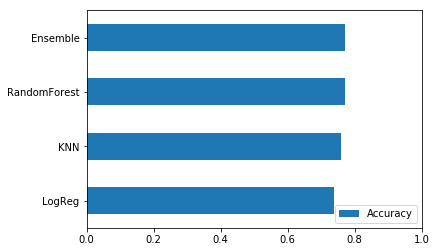

In [76]:
#Sum it all

acc_table2 = pd.DataFrame(index = ['KNN','RandomForest','LogReg','Ensemble'], columns = ['Accuracy'])
clf_table = [clf1, clf2, clf3, eclf]

j=0 #iterator
for c in clf_table:
    c.fit(X_train_reduced, y_train)
    y_pred = c.predict(X_CV_reduced)
    acc_table2.iloc[j,0] = accuracy_score(y_CV, y_pred)
    j+=1
    
acc_table2.sort_values(by='Accuracy').plot(kind='barh', xlim=(0,1))

In [86]:
#Submission

dSub = pd.read_csv('test.csv')

submission = pd.DataFrame(columns=['PassengerId','Survived'])
submission['PassengerId']=dSub['PassengerId']
submission['Survived']=eclf.predict(X_test_reduced)

submission.to_csv('submission4.csv',index=False)

/home/seb/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
